In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

D:\Software\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
class KANLayer4(tf.Module):
    def __init__(self, 
                 inpDim, 
                 outDim, 
                 GInterval, 
                 p,
                 gridRange = [-1.0, 1.0],
                 name = "", 
                 seed = 100):
        super().__init__(name=name)
        self.inpDim = tf.constant(inpDim)
        self.outDim = tf.constant(outDim)
        self.G = tf.constant(GInterval)
        self.p = tf.constant(p)
        self.seed = seed
        stddev = tf.math.sqrt(2 / (inpDim + outDim))
        self.gridRange = gridRange

        #Defining Variables
        self.W = tf.Variable(tf.random.normal([self.inpDim, self.outDim], mean = 0.0, stddev = stddev, seed = self.seed), name = name+"_W")
        self.Phi = tf.Variable(tf.random.normal([self.inpDim, self.outDim, self.G], 
                               mean = 0.0, stddev = 1, seed = self.seed), name = self.name+"_Phi")

        #Lazy construction of functions to integrate input signatures (Find better way this is shit)
        self.BSplineFunc = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][self.p]
        self.BSplineFunc = tf.function(self.BSplineFunc, input_signature=(tf.TensorSpec(shape=[None, self.inpDim], dtype = tf.float32),
                                                                         tf.TensorSpec(shape=[None, self.inpDim], dtype = tf.float32),))
        self.Spline = tf.function(self.SplineTemp, input_signature=(tf.TensorSpec(shape=[None, self.inpDim], dtype=tf.float32),))
        self.dot_matmul = tf.function(self.dot_matmulTemp, input_signature=(tf.TensorSpec(shape=[None, self.inpDim, self.G], dtype=tf.float32),
                                                                           tf.TensorSpec(shape=[self.inpDim, self.outDim, self.G], dtype=tf.float32)))

    def dot_matmulTemp(self, A, B):
        A0 = tf.squeeze(tf.slice(A, [0, 0, 0], [self.inpDimN, self.inpDim, 1]), axis = 2)
        B0 = tf.squeeze(tf.slice(B, [0, 0, 0], [self.inpDim, self.outDim, 1]), axis = 2)
        Y = tf.matmul(A0, B0)
        i = tf.constant(1)
        while(i < self.G):
            A0 = tf.squeeze(tf.slice(A, [0, 0, i], [self.inpDimN, self.inpDim, 1]), axis = 2)
            B0 = tf.squeeze(tf.slice(B, [0, 0, i], [self.inpDim, self.outDim, 1]), axis = 2)
            Y = Y + tf.matmul(A0, B0)
            i+=1
        return Y
    
    def BSpline0(self, T, Ti):
        Gdelta = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G, tf.float32)
        temp1 = tf.cast(tf.where(((Ti <= T) & (T < (Ti + Gdelta))), 1.0, 0.0), tf.float32)
        return temp1

    def BSpline1(self, T, Ti):
        Gdelta = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G, tf.float32)
        temp0 = 1 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline0(T, Ti) ) + ( diff1 * self.BSpline0(T, Ti+Gdelta) )
        return temp2

    def BSpline2(self, T, Ti):
        Gdelta = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G, tf.float32)
        temp0 = 2 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline1(T, Ti) ) + ( diff1 * self.BSpline1(T, Ti+Gdelta) )
        return temp2
        
    def BSpline3(self, T, Ti):
        Gdelta = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G, tf.float32)
        temp0 = 3 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline2(T, Ti) ) + ( diff1 * self.BSpline2(T, Ti+Gdelta) )
        return temp2
    
    def SplineTemp(self, X):
        Gdelta = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G, tf.float32)

        I = tf.floor((X - self.gridRange[0]) / Gdelta)
        I = tf.maximum(I, 0)
        I = tf.minimum(I, tf.cast(self.G-self.p-1, tf.float32))
        #I = I + self.p
        Ti = I * Gdelta + self.gridRange[0]
        tf.print(Gdelta, tf.math.reduce_min(Ti))
        I = tf.cast(I, tf.int32) + self.p
        #Ti = Ti + Gdelta * tf.cast(self.p, tf.float32)

        Res = tf.zeros(tf.concat([[self.inpDimN], [self.inpDim], [self.G]], axis = 0), dtype=tf.float32)
        Ti = Ti + Gdelta
        i = tf.constant(0)
        J = tf.expand_dims(tf.repeat(tf.expand_dims(tf.range(self.inpDimN), axis = 1), self.inpDim, axis = 1), axis = 2)
        K = tf.expand_dims(tf.repeat(tf.expand_dims(tf.range(self.inpDim), axis = 0), self.inpDimN, axis = 0), axis = 2)
        I = tf.expand_dims(I, axis = 2)
        while(i <= self.p):
            Ti = Ti - Gdelta
            Y = self.BSplineFunc(X, Ti)
            temp0 = tf.concat([J, K, (I-i)], axis = 2)
            Res = tf.tensor_scatter_nd_update(Res, temp0, Y)
            i+=1
        Ans = self.dot_matmul(Res, self.Phi)
        return Ans

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype=tf.float32),))
    def __call__(self, X):
        self.inpDimN = tf.gather_nd(tf.shape(X), [0])
        spline = self.Spline(X)
        silu = X / (1 + tf.exp(-X))
        #silu_exp = tf.matmul(silu, tf.ones([self.inpDim, self.outDim], dtype = tf.float32))
        #W = tf.matmul(tf.ones([self.inpDimN, 1], dtype = tf.float32), self.W)
        #return W * (silu_exp + spline)
        return tf.matmul(silu,  self.W) + spline
        

In [4]:
kan0 = KANLayer4(1, 10, GInterval = 2, p = 1, name = "layer0", seed = 100)

In [5]:
N = 10000
X = tf.random.uniform([N, 1], minval = -5, maxval = 5)
X = tf.sort(X, axis = 0)

time0 = tf.timestamp()
with tf.GradientTape() as tape:
    Y = kan0.__call__(X)
timedelt = tf.timestamp() - time0

dY_dK = tape.gradient(Y, kan0.trainable_variables)

1 -1


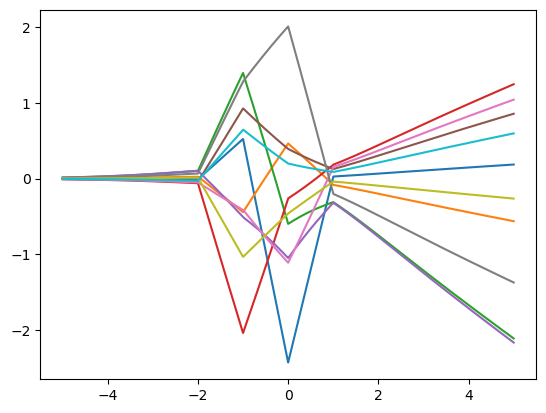

In [6]:
plt.plot(X, Y)